In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np

In [2]:
# MNIST dataset parameters.
num_classes = 10 # total classes (0-9 digits).
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
learning_rate = 0.1
training_steps = 2000
batch_size = 256
display_step = 100

# Network parameters.
n_hidden_1 = 128 # 1st layer number of neurons.
n_hidden_2 = 256 # 2nd layer number of neurons.

In [3]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [4]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [5]:
# Create TF Model.
class NeuralNet(Model):
    # Set layers.
    def __init__(self):
        super(NeuralNet, self).__init__()
        # First fully-connected hidden layer.
        self.fc1 = layers.Dense(n_hidden_1, activation=tf.nn.relu)
        # First fully-connected hidden layer.
        self.fc2 = layers.Dense(n_hidden_2, activation=tf.nn.relu)
        # Second fully-connecter hidden layer.
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

# Build neural network model.
neural_net = NeuralNet()

In [6]:
# Cross-Entropy Loss.
# Note that this will apply 'softmax' to the logits.
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

In [7]:
# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass.
        pred = neural_net(x, is_training=True)
        # Compute loss.
        loss = cross_entropy_loss(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = neural_net.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [8]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x, is_training=True)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 100, loss: 0.412719, accuracy: 0.910156
step: 200, loss: 0.282855, accuracy: 0.937500
step: 300, loss: 0.242852, accuracy: 0.925781
step: 400, loss: 0.288900, accuracy: 0.925781
step: 500, loss: 0.199585, accuracy: 0.949219
step: 600, loss: 0.219708, accuracy: 0.933594
step: 700, loss: 0.135859, accuracy: 0.960938
step: 800, loss: 0.147999, accuracy: 0.960938
step: 900, loss: 0.116704, accuracy: 0.968750
step: 1000, loss: 0.178838, accuracy: 0.960938
step: 1100, loss: 0.133223, accuracy: 0.953125
step: 1200, loss: 0.139447, accuracy: 0.964844
step: 1300, loss: 0.168910, accuracy: 0.957031
step: 1400, loss: 0.105965, accuracy: 0.976562
step: 1500, loss: 0.134825, accuracy: 0.968750
step: 1600, loss: 0.109842, accuracy: 0.972656
step: 1700, loss: 0.109746, accuracy: 0.960938
step: 1800, loss: 0.094182, accuracy: 0.980469
step: 1900, loss: 0.081600, accuracy: 0.980469
step: 2000, loss: 0.058749, accuracy: 0.992188


In [14]:
neural_net.compile(optimizer='SGD',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']
)

In [15]:
history = neural_net.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=30,
                        validation_split=0.2
)

Epoch 1/30
188/188 [==============================] - 1s 5ms/step - loss: 0.1031 - accuracy: 0.9707 - val_loss: 0.0970 - val_accuracy: 0.9728
Epoch 2/30
188/188 [==============================] - 1s 4ms/step - loss: 0.1017 - accuracy: 0.9714 - val_loss: 0.0968 - val_accuracy: 0.9737
Epoch 3/30
188/188 [==============================] - 1s 4ms/step - loss: 0.1007 - accuracy: 0.9715 - val_loss: 0.0966 - val_accuracy: 0.9732
Epoch 4/30
188/188 [==============================] - 1s 4ms/step - loss: 0.0998 - accuracy: 0.9720 - val_loss: 0.0966 - val_accuracy: 0.9732
Epoch 5/30
188/188 [==============================] - 1s 5ms/step - loss: 0.0988 - accuracy: 0.9721 - val_loss: 0.0966 - val_accuracy: 0.9727
Epoch 6/30
188/188 [==============================] - 1s 5ms/step - loss: 0.0981 - accuracy: 0.9724 - val_loss: 0.0958 - val_accuracy: 0.9738
Epoch 7/30
188/188 [==============================] - 1s 4ms/step - loss: 0.0971 - accuracy: 0.9730 - val_loss: 0.0959 - val_accuracy: 0.9732
Epoch 

In [16]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

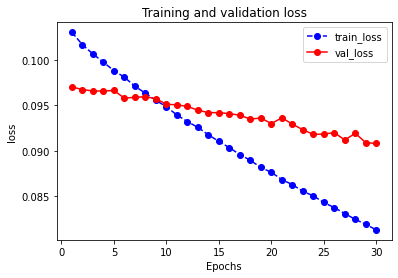

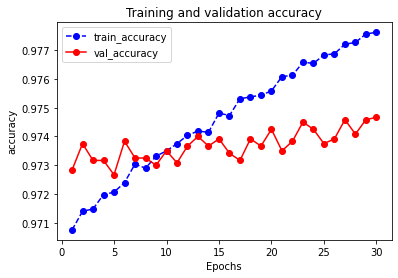

In [18]:
plot_metric(history, 'loss')
plot_metric(history, 'accuracy')

In [19]:
neural_net.evaluate(x = x_test, y = y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.1001 - accuracy: 0.9716


[0.10005529969930649, 0.9715999960899353]

In [20]:
neural_net.summary()

Model: "neural_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  100480    
_________________________________________________________________
dense_1 (Dense)              multiple                  33024     
_________________________________________________________________
dense_2 (Dense)              multiple                  2570      
Total params: 136,074
Trainable params: 136,074
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Test model on validation set.
pred = neural_net(x_test, is_training=False) 
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.965800


In [11]:
# Visualize predictions.
import matplotlib.pyplot as plt

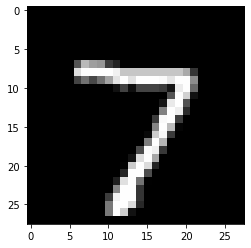

Model prediction: 7


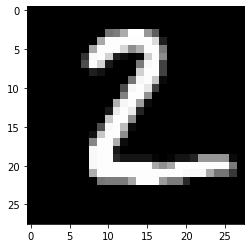

Model prediction: 2


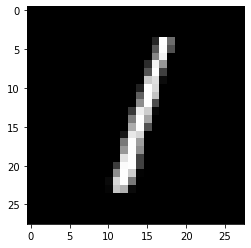

Model prediction: 1


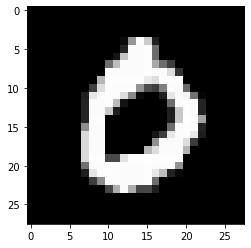

Model prediction: 0


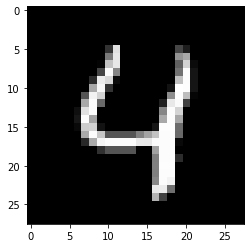

Model prediction: 4


In [12]:
# Predict 5 images from validation set.
n_images = 5
test_images = x_test[:n_images]
predictions = neural_net(test_images)

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))